
# Imports and Setup

In [1]:
import os
import torch
from torch import nn 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms 

import sklearn
import itertools 
import matplotlib.pyplot as plt
import numpy as np


In [2]:
#from polytorch import polytorch

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Using {} device'.format(device))

Using cpu device


In [4]:
def multiply(v1, v2): 
  if len(v1)!= len(v2): 
    raise ValueError("The two sign sequences must have same length")
    return
  else: 
    product = list(v1) 
    for i in range(len(product)): 
      if product[i]==0: 
        product[i] = v2[i]
  
  return tuple(product)


In [5]:
multiply((1,-1,0,1,-1),(-1,1,1,-1,1))

(1, -1, 1, 1, -1)

In [6]:
def edge_connected(v1, v2,  dim = 2): 
  p1 = multiply(v1,v2)
  p2 = multiply(v2,v1) 
  #print(p1,p2)
  if p1 == p2 and np.sum([p == 0 for p in p1 ]) == dim-1: 
    return True 
  else: 
    return False 

def is_face(v, F): 
  p = multiply(v,F)

  if p == tuple(F): 
    return True 
  else: 
    return False 

In [7]:
#start by doing 2d to 5d to 5d to 1d
#realistically we need (n choose k) to be < 10,000 or soo.... 


class NeuralNetwork(nn.Module):
    def __init__(self,architecture = (2, 10, 5)):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()

        self.linear_0 = nn.Linear(architecture[0],architecture[1])
        self.relu_0 = nn.ReLU()
        self.linear_1 = nn.Linear(architecture[1],architecture[2])
        self.relu_1 = nn.ReLU()
        self.linear_2 = nn.Linear(architecture[2],1)


    def forward(self, x):
        x = self.flatten(x)
        
        self.activity_0 = self.linear_0(x) 
        self.activity_1 = self.linear_1(self.relu_0(self.activity_0))
        self.activity_2 = self.linear_2(self.relu_1(self.activity_1))

        return self.activity_0, self.activity_1, self.activity_2

# Get Model

In [1]:
#obtain model

model = NeuralNetwork().to(device)
print(model)

NameError: name 'NeuralNetwork' is not defined

In [9]:
#obtain weights
params=list(model.parameters())
#print(params[0])

#params[0] is A, an nxr matrix
#r = input dim. n = output dim (annoyingly. pytorch.)

#make a list of combinations n choose r
n=torch.tensor(range(len(params[0]))).to(device)

combos = torch.combinations(n, r=params[0].shape[1])

#obtain weights
params=list(model.parameters())

#get indices to get every combination of
n1 =torch.tensor(range(params[0].shape[0]))
combos = torch.combinations(n1 , r=params[0].shape[1])

# solve a linear equation for every combo of indices to get intersections
# Sice params[0]=A and params[1]=b in the equation Ax+b=0, 
# solve Ax=-b in linalg.solve, for all matrices at once! 
# Nifty and zippy but requires high RAM

# NOTE: Computing decision boundaries on interesting "SLICES" of input space
# May be more feasible in practice

points = torch.linalg.solve(params[0][combos].detach(), -params[1][combos].detach()) 

#print(points)

# get sign sequences of each point, noting that if the value is zero then 
# we may have sign error due to machine eps. forces signs to be correct 

# obtains sign sequence of initial vertices
ssv = torch.hstack([torch.sign(model(points)[i]) for i in range(3)])

#print(ssv) 

#find a way to do this without loops!?! 
for i in range(len(ssv)): 
  ssv[i,combos[i]]=0

#print(ssv)

C:\Users\Marissa\AppData\Local\Temp/ipykernel_14900/1393678058.py:11: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  combos = torch.combinations(n, r=params[0].shape[1])


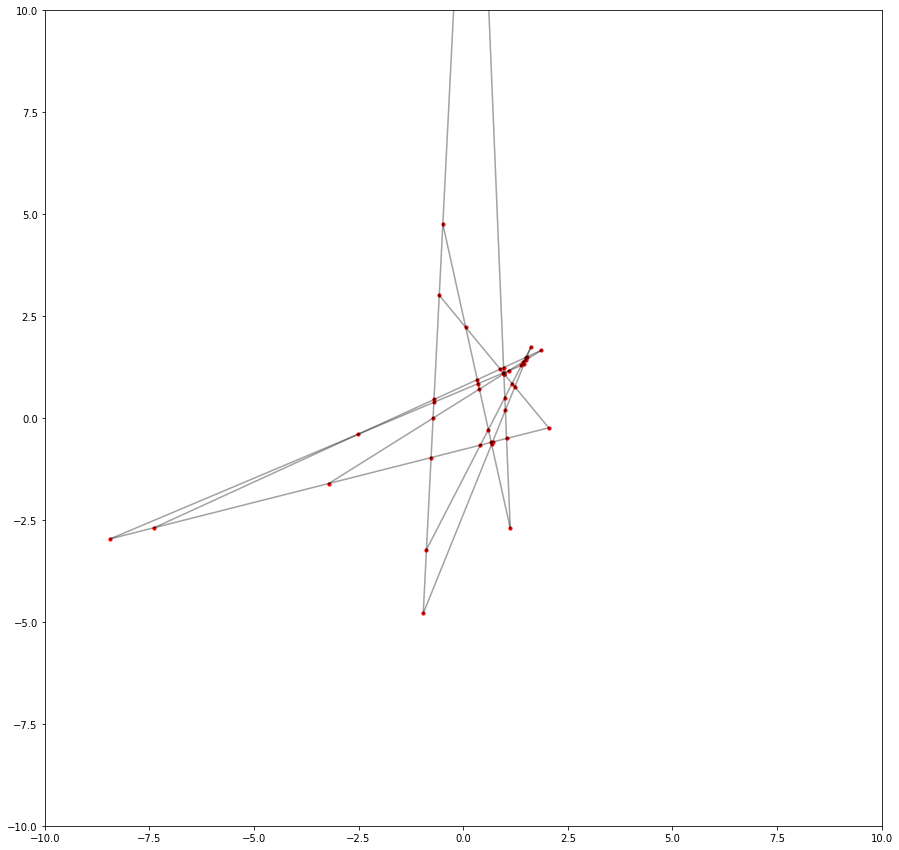

In [10]:


# observe that v & w are in the same cell iff ss(v) * ss(w) = ss(w)*ss(v)

ptplot = points.cpu().detach().numpy()


fig,ax=plt.subplots(figsize=(15,15))
ax.set_xlim((-10,10))
ax.set_ylim((-10,10))

for (i,v) in enumerate(ssv): 
  for (j,w) in enumerate(ssv): 
    if torch.sum(torch.logical_not(torch.eq(v[0:len(params[0])],w[0:len(params[0])])))==2: 
      ax.plot(*np.vstack([ptplot[i],ptplot[j]]).T, c='black',alpha=.2)

ax.scatter(*ptplot.T, s=10, c='red')


In [11]:
#for the second layer, now using params[1] & product. 

#record the existing vertex ss as np arrays
ssv_np = [np.array(ss[0:len(params[0])].detach().numpy(),dtype='int') for ss in ssv]

#record the regions that are present as a set 
ssr = set() 

#loop through vertices and obtain regions which are adjacent
for ss in ssv_np: 
  locs = np.where(ss==0)
  #print(locs) 
  tempss=np.copy(ss)

  signs = [[1,1],[-1,-1],[1,-1],[-1,1]]
  tempss=np.copy(ss) 

  for sign in signs: 
    tempss[locs]=sign
    ssr.add(tuple(tempss))

print(len(ssr))

56


In [12]:
ssr

{(-1, -1, -1, -1, -1, -1, -1, -1, 1, -1),
 (-1, -1, -1, -1, -1, -1, -1, -1, 1, 1),
 (-1, -1, -1, -1, -1, -1, -1, 1, -1, 1),
 (-1, -1, -1, -1, -1, -1, -1, 1, 1, -1),
 (-1, -1, -1, -1, -1, -1, -1, 1, 1, 1),
 (-1, -1, -1, -1, -1, -1, 1, 1, -1, 1),
 (-1, -1, -1, -1, -1, 1, -1, -1, -1, -1),
 (-1, -1, -1, -1, -1, 1, -1, -1, -1, 1),
 (-1, -1, -1, -1, -1, 1, -1, -1, 1, -1),
 (-1, -1, -1, -1, -1, 1, -1, -1, 1, 1),
 (-1, -1, -1, -1, -1, 1, -1, 1, -1, 1),
 (-1, -1, -1, -1, -1, 1, -1, 1, 1, 1),
 (-1, -1, -1, -1, -1, 1, 1, -1, -1, 1),
 (-1, -1, -1, -1, -1, 1, 1, 1, -1, 1),
 (-1, -1, -1, -1, 1, -1, -1, -1, 1, -1),
 (-1, -1, -1, -1, 1, -1, -1, 1, -1, 1),
 (-1, -1, -1, -1, 1, -1, -1, 1, 1, -1),
 (-1, -1, -1, -1, 1, -1, -1, 1, 1, 1),
 (-1, -1, -1, -1, 1, -1, 1, 1, -1, 1),
 (-1, -1, -1, 1, -1, -1, -1, -1, 1, -1),
 (-1, -1, -1, 1, -1, 1, -1, -1, 1, -1),
 (-1, -1, -1, 1, 1, -1, -1, -1, 1, -1),
 (-1, -1, -1, 1, 1, -1, -1, 1, 1, -1),
 (-1, -1, 1, -1, 1, -1, -1, 1, -1, 1),
 (-1, -1, 1, -1, 1, -1, -1, 1, 1, -

In [13]:

def make_affine(matrix, bias):
  A = torch.hstack([matrix, bias.reshape(len(matrix),1)])
  A = torch.vstack([A,torch.zeros(1,A.shape[1])])
  A[-1,-1]=1 
  return A 

def make_linear(affine_matrix): 
  matrix = affine_matrix[0:-1,0:-1]
  bias = affine_matrix[:-1,-1]
  return matrix,bias

In [14]:
#obtain affine maps for each region 

def get_region_map(ss,param_list): 
  base_A = make_affine(param_list[0],param_list[1])
  region_indices = np.where(np.array(list(ss))==-1)
  r_map = torch.clone(base_A)
  r_map[region_indices,:] = 0
  
  return r_map 

In [15]:
ss = list(ssr)[0]
print(ss)
rmap = get_region_map(ss,params).detach()
print(rmap)

secondlayer_map = make_affine(params[2],params[3]).detach()

print(secondlayer_map@rmap)


(-1, -1, -1, -1, 1, -1, -1, 1, -1, 1)
tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [-0.6601,  0.3315,  0.4903],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [-0.1173,  0.4512,  0.3472],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.4398,  0.0949, -0.2378],
        [ 0.0000,  0.0000,  1.0000]])
tensor([[-0.0708, -0.0050, -0.1876],
        [ 0.0302,  0.0402, -0.2176],
        [ 0.0999, -0.0084,  0.0944],
        [-0.1764, -0.0414,  0.1775],
        [-0.2538,  0.1030,  0.1058],
        [ 0.0000,  0.0000,  1.0000]])


C:\Users\Marissa\AppData\Local\Temp/ipykernel_14900/3384278984.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  r_map[region_indices,:] = 0


In [16]:
#loop through regions in layer 1. 
secondlayer_map = make_affine(params[2],params[3]).detach()

l2_points = []
l2_ssv = []

for ss in ssr: 
  #get the map associated with the sign sequence 
  region_map = get_region_map(ss,params).detach()

  # get the resulting affine map associated with first layer map on region
  # followed by 

  total_map, total_bias = make_linear((secondlayer_map @ region_map).detach())

  #region_linear, region_bias = make_linear((region_map).detach()) 
  # loop through pairs of neurons. Start with pairs of neurons from layer 2. 

  total_bias.reshape((len(total_bias),1))
  #print(total_map, total_bias)

  n2=torch.tensor(range(total_map.shape[0])).to(device)

  combos = torch.combinations(n2,r=params[0].shape[1])

  temp_points = torch.linalg.solve(total_map[combos],-total_bias[combos])
 
  
  #evaluate model on these points and add to ssv if they have appropriate signs 
  ssv_l2_temp = torch.hstack([torch.sign(model(temp_points)[i]) for i in range(3)]).detach().numpy()
  for i in range(len(ssv_l2_temp)): 
    ssv_l2_temp[i,(combos[i]+len(params[0]))]=0 
    
  #only keep vertices which have same sign sequence as ss in first layer 
  #print(ssv_l2_temp)
  #print(temp_ss)
  for  temp_pt, temp_ss in zip(temp_points, ssv_l2_temp): 
    #print(temp_ss,'\n',ss)
    if is_face(temp_ss[0:len(params[0])],ss): 
      l2_points.append(temp_pt.detach().numpy()) 
      l2_ssv.append(tuple(temp_ss.astype(int))) 

#  next go through pairs of neurons in layer 1 and layer 2, but only the neurons
#  in layer 1 which abut this region because what's the point otherwise. 

  #print(len(l2_points))
  #print(region_linear.shape, region_bias.shape, total_map.shape, total_bias.shape)
  #print(n1, n2)
  all_matrices = torch.vstack([params[0][n1],total_map[n2]])
  #print(params[0][n1])
  all_biases = torch.hstack([params[1][n1],total_bias[n2]])
#  .reshape((len(all_matrices),2))
 # print(all_biases)
  temp_pts = []
  ssv_l2_temp = []
  for i,j in torch.cartesian_prod(n1,n2): 
    #if torch.det()
      #some pairs of hyperplanes will and must be exactly parallel here maybe 
      #in some situations. Not sure what to do about it at the moment

    point = torch.linalg.solve(torch.vstack([params[0][i],total_map[j]]), 
                                  -torch.tensor([params[1][i],total_bias[j]]))
    temp_pts.append(point)
    
    #print(temp_pts)
    temp_ssv = torch.hstack(
        [torch.sign(model(point.reshape(1,2))[i]) for i in range(3)])
    temp_ssv[0,i] = 0 
    temp_ssv[0,j+len(params[0])] = 0 

    ssv_l2_temp.extend(temp_ssv.detach().numpy())

  for  temp_pt, temp_ss in zip(temp_pts, ssv_l2_temp): 
    #check if point is in ss. 
    #print(temp_ss,ss)
    if is_face(temp_ss[0:len(params[0])], ss): 
      l2_points.append(temp_pt.detach().numpy()) 
      l2_ssv.append(tuple(temp_ss.astype(int))) 
      #print("TRUE")
    


#print(new_points)



In [17]:
print(len(l2_points))
print(len(l2_ssv))

104
104


In [18]:

l2_ssv = torch.tensor(l2_ssv,requires_grad=False)
all_ssv = torch.vstack([ssv, l2_ssv])
all_points = np.vstack([ptplot, l2_points])

plot_dict = {} 

for v,pt in zip(np.array(ssv.detach().numpy(),dtype='int'),ptplot): 
  plot_dict[tuple(v)] = pt

for v,pt in zip(l2_ssv,l2_points): 
  plot_dict[tuple(v)]=pt 

print(len(plot_dict))

149


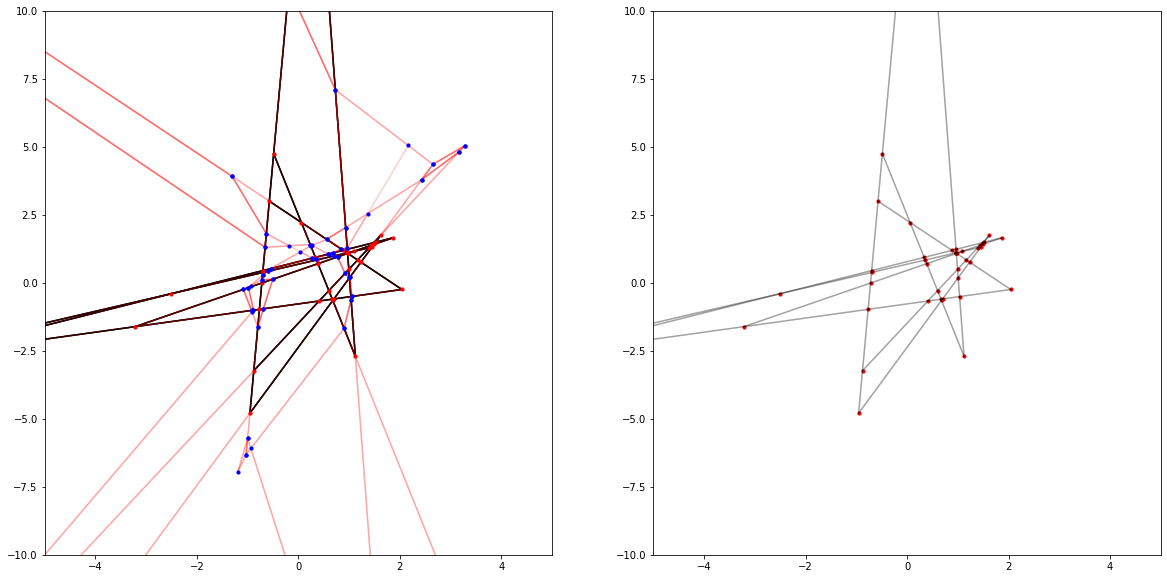

In [19]:
fig,ax=plt.subplots(1,2,figsize=(20,10))
ax[0].set_xlim((-5,5))
ax[0].set_ylim((-10,10))
ax[1].set_xlim((-5,5))
ax[1].set_ylim((-10,10))


# for (i,v) in enumerate(all_ssv): 
#   for (j,w) in enumerate(all_ssv): 
#     if edge_connected(v.detach().numpy(),w.detach().numpy()): 
#       ax[0].plot(*np.vstack([all_points[i],all_points[j]]).T, c='black',alpha=.2)


# print(list(plot_dict.values()))

# for (i,v) in enumerate(ssv): 
#   for (j,w) in enumerate(ssv): 
#     #determine which pairs are in same face. NOT GOOD ENOUGH UNIVERSE! 

#     if edge_connected(v.detach().numpy(),w.detach().numpy()): 
#       ax[1].plot(*np.vstack([ptplot[i],ptplot[j]]).T, c='black',alpha=.2)

# ax[0].scatter(*ptplot.T,s=10, c='red')
# ax[0].scatter(*np.array(l2_points).T,s=10,c='blue')

for v in plot_dict: 
  #print(len(v))
  for w in plot_dict: 
    #check 
    if edge_connected(v[0:len(v)-1],w[0:len(v)-1]): 
      #print(plot_dict[v],plot_dict[w])
      
      ax[0].plot(*np.vstack([plot_dict[v],plot_dict[w]]).T, c='red',alpha=.1,zorder=1)
  
#show points in plot_dict 

ax[0].scatter(*np.array(l2_points).T,s=10,c='blue',zorder=2)
ax[0].scatter(*ptplot.T, s=10, c='red')


for (i,v) in enumerate(ssv): 
  for (j,w) in enumerate(ssv): 
    if edge_connected(v[0:len(params[0])],w[0:len(params[0])]): 
      ax[0].plot(*np.vstack([ptplot[i],ptplot[j]]).T, c='black',alpha=1,zorder=0)
      ax[1].plot(*np.vstack([ptplot[i],ptplot[j]]).T, c='black',alpha=.2)


ax[1].scatter(*ptplot.T, s=10, c='red')

plt.show()

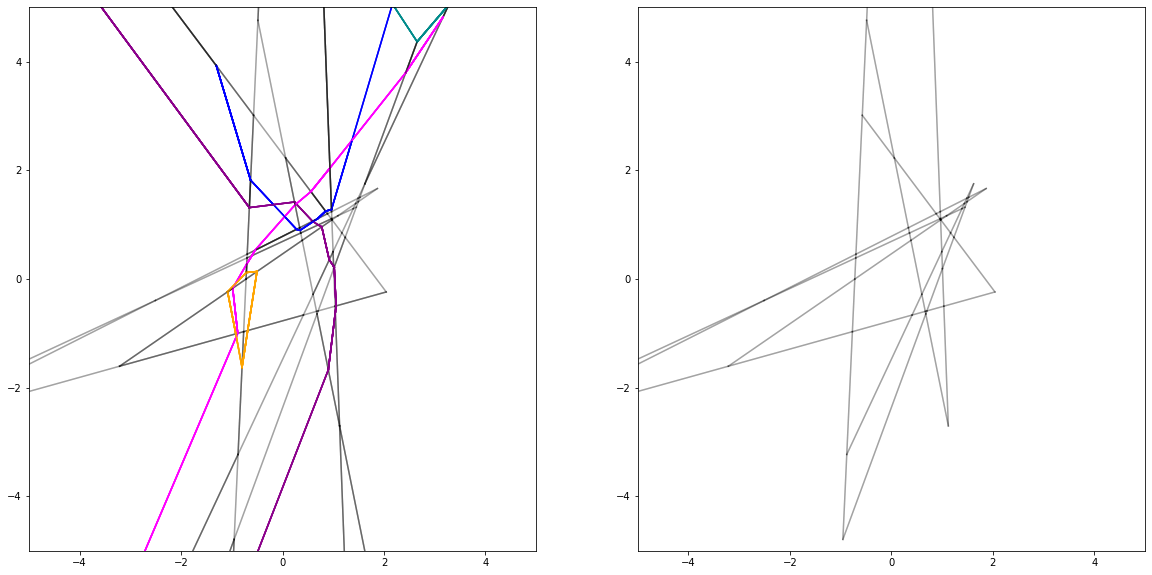

In [22]:
fig,ax=plt.subplots(1,2,figsize=(20,10))
bound=5

ax[0].set_xlim((-bound,bound))
ax[0].set_ylim((-bound,bound))
ax[1].set_xlim((-bound,bound))
ax[1].set_ylim((-bound,bound))

colors = ['black']*len(params[0]) + ["magenta","darkcyan","orange","darkmagenta","blue"]

# for (i,v) in enumerate(all_ssv): 
#   for (j,w) in enumerate(all_ssv): 
#     if edge_connected(v.detach().numpy(),w.detach().numpy()): 
#       ax[0].plot(*np.vstack([all_points[i],all_points[j]]).T, c='black',alpha=.2)


# print(list(plot_dict.values()))

# for (i,v) in enumerate(ssv): 
#   for (j,w) in enumerate(ssv): 
#     #determine which pairs are in same face. NOT GOOD ENOUGH UNIVERSE! 

#     if edge_connected(v.detach().numpy(),w.detach().numpy()): 
#       ax[1].plot(*np.vstack([ptplot[i],ptplot[j]]).T, c='black',alpha=.2)

# ax[0].scatter(*ptplot.T,s=10, c='red')
# ax[0].scatter(*np.array(l2_points).T,s=10,c='blue')

for v in plot_dict: 
  #print(len(v))
  for w in plot_dict: 
    #check 
    if edge_connected(v[0:len(v)-1],w[0:len(v)-1]): 
      #print(plot_dict[v],plot_dict[w])
      #print(v,w)
      hyper_set = set(np.where(np.array(v)==0)[0]).intersection(set(np.where(np.array(w)==0)[0]))
      hyper = hyper_set.pop()
      color = colors[hyper]
      if color=="black":
        ax[0].plot(*np.vstack([plot_dict[v],plot_dict[w]]).T, c=color,alpha=.2,zorder=1)
      else:
        ax[0].plot(*np.vstack([plot_dict[v],plot_dict[w]]).T, c=color,alpha=1,zorder=1)
  
#show points in plot_dict 

#ax[0].scatter(*np.array(l2_points).T,s=10,c='blue',zorder=2)
#ax[0].scatter(*ptplot.T, s=10, c='red')


for (i,v) in enumerate(ssv): 
  for (j,w) in enumerate(ssv): 
    if edge_connected(v[0:len(params[0])],w[0:len(params[0])]): 
      #ax[0].plot(*np.vstack([ptplot[i],ptplot[j]]).T, c='black',alpha=.5,zorder=0)
      ax[1].plot(*np.vstack([ptplot[i],ptplot[j]]).T, c='black',alpha=.2)


#ax[1].scatter(*ptplot.T, s=10, c='red')

plt.show()

In [21]:
#print(v)
